# Set up

Import required packages and set up the workspace.

In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import json
from datetime import datetime, timedelta
from azureml.core import Workspace, Datastore, Dataset, Experiment
from azureml.data.datapath import DataPath

workspace = Workspace.from_config()

# Synthesize and Register Dataset

In this section, we generate synthesized sales history data with three possible generation modes: (1) Random, (2) Sinusoid, and (3) Sparse to represent different sales data behaviors. Consider replacing with real sales data when using this solution accelerator in your own project.

In [2]:
from enum import Enum

class SalesDataModel(Enum):
    RANDOM = 0
    SINUSOID = 1
    SPARSE = 2

The Sales Data Generator generates a dataframe with the following attributes: Item, Location, Sales, and Item Class. 

In [3]:
from typing import List, Mapping

class SalesDataGenerator:
    def __init__(
        self,
        start_date: datetime,
        num_days: int,
        item_to_location: Mapping[str, List[str]],
        item_to_class: Mapping[str, List[str]],
        min_sales_per_day: int = 0,
        max_sales_per_day: int = 1000,
    ):
        self.start_date = start_date
        self.num_days = num_days
        self.item_to_location = item_to_location
        self.item_to_class = item_to_class
        self.min_sales_per_day = min_sales_per_day
        self.max_sales_per_day = max_sales_per_day

    def synthesize(self, data_model: SalesDataModel = SalesDataModel.RANDOM):
        sales_df = pd.DataFrame(columns=["Date", "Item", "Location", "Sales"])
        for item, locations in self.item_to_location.items():
            for location in locations:
                if data_model == SalesDataModel.RANDOM:
                    sales = np.random.randint(
                        self.min_sales_per_day, self.max_sales_per_day, self.num_days
                    )
                elif data_model == SalesDataModel.SINUSOID:
                    alpha = 0.9
                    gain = alpha * (self.max_sales_per_day - self.min_sales_per_day)
                    periods = np.random.randint(1, 6, 1)
                    nn = np.linspace(0, int(periods), self.num_days)
                    base_sales = (
                        gain * np.abs(np.cos(np.pi * nn))
                        + alpha * self.min_sales_per_day
                    )
                    noise = np.random.randint(
                        (1 - alpha) * self.min_sales_per_day,
                        (1 - alpha) * self.max_sales_per_day,
                        self.num_days,
                    )
                    sales = base_sales + noise
                    sales = sales.astype(int).tolist()
                elif data_model == SalesDataModel.SPARSE:
                    thresh = 0.1
                    sales = [
                        0
                        if np.random.rand() > thresh
                        else np.random.randint(
                            self.min_sales_per_day, self.max_sales_per_day, 1
                        )
                        for _ in range(self.num_days)
                    ]
                _sales_df = pd.DataFrame(
                    {
                        "Date": [
                            self.start_date + timedelta(days=diff)
                            for diff in range(self.num_days)
                        ],
                        "Item": [item] * self.num_days,
                        "Location": [location] * self.num_days,
                        "Sales": sales,
                        "Item Class": [self.item_to_class[item]] * self.num_days,
                    }
                )
                sales_df = pd.concat([sales_df, _sales_df], ignore_index=True)
        
        # hnd, ord, bkd generation
        items = list(self.item_to_location.keys())
        qtyoh, cost, tons, unit_cost = [], [], [], []
        for item in items: 
            # QTYOH Randomly selected beween min_sales and max_sales
            _qtyoh = random.randint(
                min(0, self.min_sales_per_day), 
                self.max_sales_per_day
            )
            qtyoh.append(_qtyoh)
            # Tons is randomly chosen between 1 and 10 tons
            tons.append(
                _qtyoh * max(1.0, 10 * random.random())
            )
            # Cost is randomly selected bewteen 1 and 100
            _cost = round(max(1.0, 100 * random.random()), 2)
            cost.append(_cost)
            unit_cost.append(_cost / _qtyoh)

        hnd_df = pd.DataFrame(
            {
                "Item": items,
                "QTYOH": qtyoh,
                "Cost": cost, 
                "Tons": tons,
            }
        )
        
        # percentage randomly selected representing the percent of qtyoh that will be ordered
        coeff = round(random.random(), 2)
        # Each arrival is randomly selected over the sales generation window 
        arrival_dates = [
            self.start_date + timedelta(days=random.randint(0, self.num_days))
            for _ in range(len(items))
        ]
        ord_df = pd.DataFrame(
            {
                "Item": items, 
                "Total Cost": [coeff * c for c in cost],
                "Tons": [coeff * t for t in tons],
                "Quantity": [coeff * q for q in qtyoh], 
                "Arrival Date": arrival_dates,
            }
        )
        # shipping is chosen to be randomly between 2 and 5 days
        bkd_df = pd.DataFrame(
            {
                "Item": items, 
                "Ship Date": [sd + timedelta(days=random.choice([2,3,4,5])) for sd in arrival_dates],
                "Qty Remain": [(1-coeff) * q for q in qtyoh],
            }
        )

        return sales_df, hnd_df, ord_df, bkd_df

The following cell defines the parameters for the data generation including the number of time periods (days) and number of items per location and locations.

In [4]:
num_days = 180
items = [f"Item {idx}" for idx in range(5)]
locations = [f"Location {idx}" for idx in range(3)]
item_to_class = {
    item: random.choice(["Item Class A", "Item Class B", "Item Class C"])
    for item in items
}

The next cell invokes the synthesizer.

In [5]:
generator = SalesDataGenerator(
    start_date=datetime.today().date() - timedelta(days=num_days),
    num_days=num_days,
    item_to_location={item: locations for item in items},
    item_to_class=item_to_class,
    max_sales_per_day=1000,
    min_sales_per_day=-100,
)
sales_data, hnd_data, ord_data, bkd_data = generator.synthesize(data_model=SalesDataModel.SINUSOID)
sales_data.head()

,Date,Item,Location,Sales,Item Class
0,2022-05-13,Item 0,Location 0,935,Item Class B
1,2022-05-14,Item 0,Location 0,949,Item Class B
2,2022-05-15,Item 0,Location 0,980,Item Class B
3,2022-05-16,Item 0,Location 0,963,Item Class B
4,2022-05-17,Item 0,Location 0,925,Item Class B


Next, we export the data to a local file & Register it into AML Default Datastore (GG Added 10/26/22)

In [6]:
sales_data.to_csv("./data/synthesized-sales.csv") ###TODO - this needs to be passed by the PowerApps: 

# Upload data to AzureML Datastore
ds = workspace.get_default_datastore()
ds = Dataset.File.upload_directory(src_dir='./data/',
            target=DataPath(ds, 'supply-chain'),
            show_progress=False, overwrite=False)

# Register file dataset with AzureML
ds = ds.register(workspace=workspace, name="synthesized-sales", description="Synthetic demand history data for demo", create_new_version=True)

print(f'Dataset {ds.name} registered.')

Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'


Dataset synthesized-sales registered.


# Model Training

Now we train the DeepAR Forecasting model with the registered dataset and selected hyperparameters. The training script is located at the path ../training/train.py. 

Note: The code below envokes the training script with the  `--local` flag. For submitting the training script to remote compute do not include this flag.

In [15]:
!python --version

Python 3.8.5


In [16]:
!which python

/anaconda/envs/azureml_py38/bin//python


In [14]:
!/anaconda/envs/supplychain/bin/python training/train.py --epochs 5 --learning_rate 1e-2 --num_batches_per_epoch 10 \
    --dataset_name synthesized-sales --prediction_length 30 --context_length 150 --local True

/anaconda/envs/supplychain/lib/python3.8/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
100%|█████████| 10/10 [00:01<00:00,  6.53it/s, epoch=5/5, avg_epoch_loss=-.0675]


# Register Model

Next we use AML MLClient to retrieve required credential information and register the trained model from the saved model pickle file.

In [17]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
workspace = Workspace.from_config()

ml_client = MLClient(DefaultAzureCredential(), workspace.subscription_id, workspace.resource_group, workspace.name)

In [18]:
from azure.ai.ml.entities import Model
from azure.ai.ml.constants import ModelType
import pickle

file_model = Model(
    path="outputs/model/predictor.pkl",
    type="custom_model",
    name="supply-chain-forecast-model",
    description="Supply Chain Forecasting Model from Local Training."
)
ml_client.models.create_or_update(file_model)

Uploading predictor.pkl (< 1 MB): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30.0k/30.0k [00:00<00:00, 360kB/s]


Model({'job_name': None, 'is_anonymous': False, 'auto_increment_version': False, 'name': 'supply-chain-forecast-model', 'description': 'Supply Chain Forecasting Model from Local Training.', 'tags': {}, 'properties': {}, 'id': '/subscriptions/09a78dd6-f0f2-4e40-a7e8-3959c45bceb6/resourceGroups/sa_supplychain/providers/Microsoft.MachineLearningServices/workspaces/mlw-amlsc-kgdm/models/supply-chain-forecast-model/versions/2', 'Resource__source_path': None, 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/amlsc-ci001/code/Supply-Chain-Management/Code/Notebooks', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x7ff5a46af2e0>, 'serialize': <msrest.serialization.Serializer object at 0x7ff5a46fad30>, 'version': '2', 'latest_version': None, 'path': 'azureml://subscriptions/09a78dd6-f0f2-4e40-a7e8-3959c45bceb6/resourceGroups/sa_supplychain/workspaces/mlw-amlsc-kgdm/datastores/workspaceblobstore/paths/LocalUpload/e2b86dff5235296e15dd12a817879642/predictor

# Download and run model

Next, we download the registered model to prepare for inference with test data.

In [20]:
ml_client.models.download(name="supply-chain-forecast-model", version="1", download_path="downloads/")
predictor = pickle.load(open('downloads/supply-chain-forecast-model/predictor.pkl', 'rb'))


/anaconda/envs/supplychain/lib/python3.8/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In order to run the model on data, we generate some additional test data and preprocess / transform it into the format expected by GluonTS models. Similar to the training data, consider replacing with real testing data (sales history time series) in your project.

In [21]:
from gluonts.dataset.common import load_datasets, ListDataset
from gluonts.dataset.field_names import FieldName

# Generate new data to perform inference on
test_data = generator.synthesize(data_model=SalesDataModel.SINUSOID)

start = sales_data.Date.min()
end = sales_data.Date.max()
ensemble = []
dates = list(pd.date_range(start, end))
for item in set(sales_data.Item): 
    for location in set(sales_data.Location):
        sales = sales_data[(sales_data.Item == item) & (sales_data.Location == location)].Sales.values
        if len(sales): 
            scale = max(abs(sales))
            ensemble.append(
                {
                    "class": item_to_class[item],
                    "item": item,
                    "sales": sales,
                    "start": start,
                    "end": end,
                    "total": sum(sales),
                    "scale": scale,
                    "location": location,
                    "sales_scaled": sales / scale,
                }
            )
ensemble = sorted(ensemble, key=lambda k: k["total"], reverse=True)

static_cats = [(e["class"].strip(), e["item"].strip(), e["location"].strip()) for e in ensemble]

item_to_index = {item: idx for idx, item in enumerate(set([sc[0] for sc in static_cats]))}
item_class_to_index = {item: idx for idx, item in enumerate(set([sc[1] for sc in static_cats]))}
location_to_index = {loc: idx for idx, loc in enumerate(set([sc[2] for sc in static_cats]))}


test_values = np.array([np.array(e["sales_scaled"]) for e in ensemble])

test_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start,
        FieldName.FEAT_STATIC_CAT: [
            item_to_index[sc_item], 
            item_class_to_index[sc_item_class], 
            location_to_index[sc_location]
        ],
    }
    for target, (sc_item, sc_item_class, sc_location) in zip(test_values, static_cats)
], freq="D")

Perform inference on the test data with the parameter for number of samples (samples of probablistic output) being set to 250. The model will output a matrix with 250 time series based on the probablistic prediction.

In [22]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(dataset=test_ds, predictor=predictor, num_samples=250)
forecasts = [f for f in forecast_it]
tss = list(ts_it)

For a selected time series (depicted example of index = 0 below), we output the mean, upper, and lower bounds of the sales predictions. The user can choose to either select pointwise min and max based on the 250 samples (section below) or choose the time series with the maximum value and the time series with the minimum value (section at the end) as the bounding outputs.

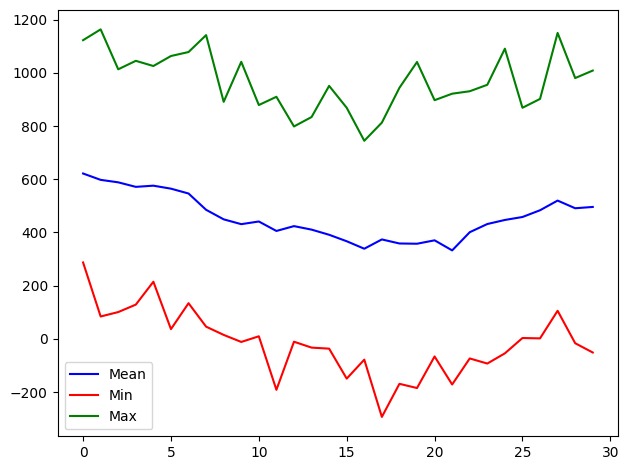

In [23]:
# Select a time series to evaluate the predictions of idx
idx = 0
f, ts, scale = forecasts[idx], tss[idx], ensemble[idx]['scale']

# Show the min/mean/max per time sample
f_mean = scale * f.samples.mean(axis=0)
f_max = scale * f.samples.max(axis=0)
f_min = scale * f.samples.min(axis=0)

plt.plot(f_mean, 'b')
plt.plot(f_min, 'r')
plt.plot(f_max, 'g')
plt.gcf().tight_layout()
plt.legend(["Mean", "Min", "Max"])
plt.show()

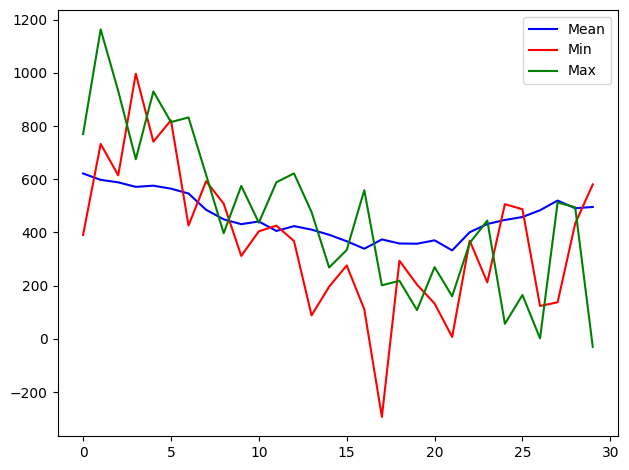

In [24]:
# Extract time series forecast on sample idx
idx = 0
f, ts, scale = forecasts[idx], tss[idx], ensemble[idx]['scale']

# Show the mean and the time samples that achieve the global min and max values

r_max, _ = np.unravel_index(np.argmax(f.samples), np.array(f.samples).shape)
r_min, _ = np.unravel_index(np.argmin(f.samples), np.array(f.samples).shape)

f_mean = scale * f.samples.mean(axis=0)
f_max = scale * f.samples[r_max, :]
f_min = scale * f.samples[r_min, :]

plt.plot(f_mean, 'b')
plt.plot(f_min, 'r')
plt.plot(f_max, 'g')
plt.gcf().tight_layout()
plt.legend(["Mean", "Min", "Max"])

plt.show()